# Imports

In [1]:
import pickle
import datetime

import numpy as np
import pandas as pd


from matplotlib             import pyplot as plt
from matplotlib.gridspec    import GridSpec
from prophet                import Prophet

from IPython.display        import Image
from IPython.core.display   import HTML

from sklearn.preprocessing  import (StandardScaler, RobustScaler)

In [2]:
with open('../data/interim/3_0_feature_engineering.pkl', 'rb') as arquivo:
    df = pickle.load(arquivo)
df.sample()

,subscription_guid,date,resource_guid,service_name,service_type,service_region,service_resource,quantity,cost,maquina,...,semana_ano,ano_semana,ano_mes,dia_da_semana,fim_de_semana,custo_fixo_diario,custo_fixo_semanal,custo_fixo_mensal,custo_soma_movel_semanal,custo_soma_movel_mensal
25774,0b1856f5_ffb1_4fb2_9b31_ebc3ddeacf68,2024-08-13,40551b4c_e8be_48ed_b70b_f8d25c7de724,Storage,General Block Blob,All,Read Operations,0.0012,0.0,ceaec,...,33,2024-33,2024-08,1,0,7.003915,48.647189,215.495763,48.693561,208.431449


CEAEC - 07 Jan 2025 - Mais ou menos - Aqui.

Editares - 08 Sep 2025 - Mais variado, talvez tenha que aumentar disco - Depois.

UNICIN - 12 Mar 2025 - Menos mexido - Aqui.

ICNET - ????

Normalmente, os créditos são disponibilizados 30 dias antes.

In [3]:
df['service_name'].unique()

array(['Storage', 'Azure DNS', 'Bandwidth', 'Virtual Network',
       'Log Analytics', 'Virtual Machines', 'Virtual Machines Licenses',
       'Automation', 'Azure Monitor', 'Network Watcher', 'SQL Database',
       'Azure App Service', 'Backup', 'Key Vault', 'Functions',
       'Logic Apps'], dtype=object)

### Filtro Máquina

In [45]:
df_maquina = df[
        (df['maquina'] == 'icnet') &
        (df['service_name'] != 'Functions')
        ]

In [46]:
df_maquina['date'].max()

Timestamp('2024-11-16 00:00:00')

In [47]:
df_maquina['date'].min()

Timestamp('2024-03-09 00:00:00')

### Isolamento das variáveis

In [48]:
df_plot = df_maquina.loc[
            (df_maquina['date']>= '2024-01-01') &
            (df_maquina['date']<= '2024-11-15')
            ,
                [
                'date',
                'cost'
                ]
            ].groupby('date').sum().reset_index()

# plt.scatter(
#     df_plot['date'],
#     df_plot['cost'])
# df_plot.shape[0]
# df_plot

In [49]:
df_plot['cost'].sum()

1974.1955540000004

In [50]:
#filtro_data = (df["Date"])
#filtro_service_name = df['ServiceName'] == "Functions"
#filtro_service_resource = df['ServiceResource'] == "Premium vCPU Duration"

df_prep = df_maquina.loc[:, ["date", "cost"]].groupby("date").sum().reset_index()

In [51]:
df_prep.rename(columns = {"date":"ds", "cost":"y"}, inplace = True)

In [52]:
df_prep = df_prep.loc[df_prep['ds'] >= '2024-01-01',:]

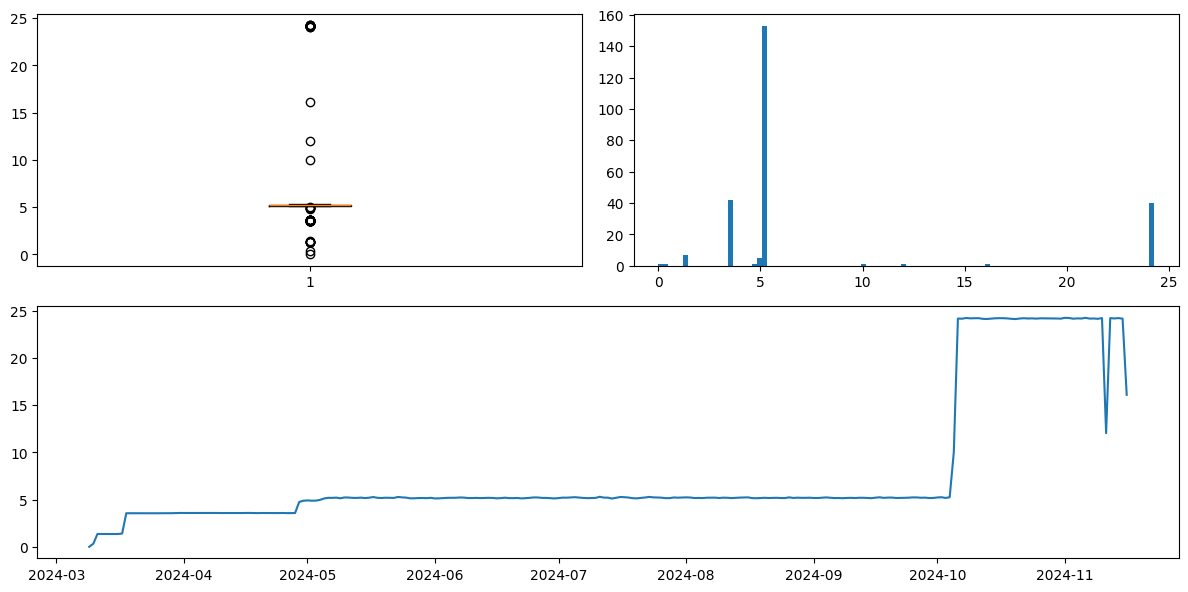

In [53]:
fig, axes = plt.subplots(2,2, figsize=(12,6))

fig.delaxes(axes[1, 1])
fig.delaxes(axes[1, 0])

axes[0,0].boxplot(df_prep['y']);

axes[0,1].hist(df_prep['y'],bins=100)

ax3 = fig.add_subplot(2,1,2)
ax3.plot(df_prep['ds'], df_prep['y'])

plt.tight_layout()
plt.show()

In [58]:
df_prep.loc[df_prep['ds']>= '2024-10-06',['y']].sum()

y    995.557011
dtype: float64

### Normalização dos dados e Reescala Z-score

In [13]:
df_model = df_prep.copy()

In [14]:
df_model['y'] = np.log1p(df_model['y'])

In [15]:
scaller = StandardScaler()
df_model['y'] = scaller.fit_transform(df_model[['y']])

#robst = RobustScaler()
#df_model['y'] = robst.fit_transform(df_model[['y']])

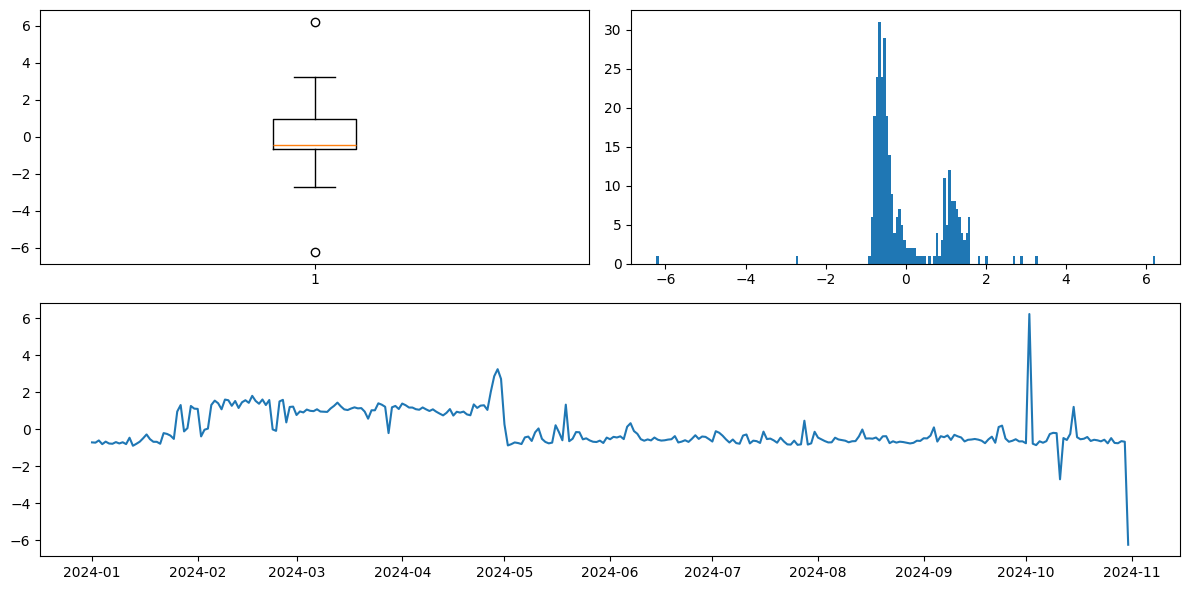

In [16]:
# plt.figure(figsize=(12, 5))
# plt.subplot(1,2,1)
# plt.boxplot(df_model['y']);

# plt.subplot(1,2,2)
# plt.plot(df_model['ds'], df_model['y'])

fig_model, axes_model = plt.subplots(2,2, figsize=(12,6))

fig_model.delaxes(axes_model[1, 1])
fig_model.delaxes(axes_model[1, 0])

axes_model[0,0].boxplot(df_model['y']);

axes_model[0,1].hist(df_model['y'],bins=200)

ax3 = fig_model.add_subplot(2,1,2)
ax3.plot(df_model['ds'], df_model['y'])

plt.tight_layout()
plt.show()

### Separação Treino x Teste

In [17]:
df_train = df_model.loc[df_model['ds'] <= '2024-09-30',:]
df_test = df_model.loc[df_model['ds'] > '2024-09-30',:]

In [18]:
#df_train.tail(5)

In [18]:
m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=30)
future.info()

15:35:59 - cmdstanpy - INFO - Chain [1] start processing
15:36:00 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      304 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.5 KB


In [19]:
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [20]:
ds_future = forecast

In [21]:
futuro = ds_future.loc[ds_future["ds"] > "2024-09-30", [
                                                        'ds',
                                                        'yhat',
                                                        'yhat_lower',
                                                        'yhat_upper'
                                                        ]
                        ].groupby("ds").sum().reset_index()

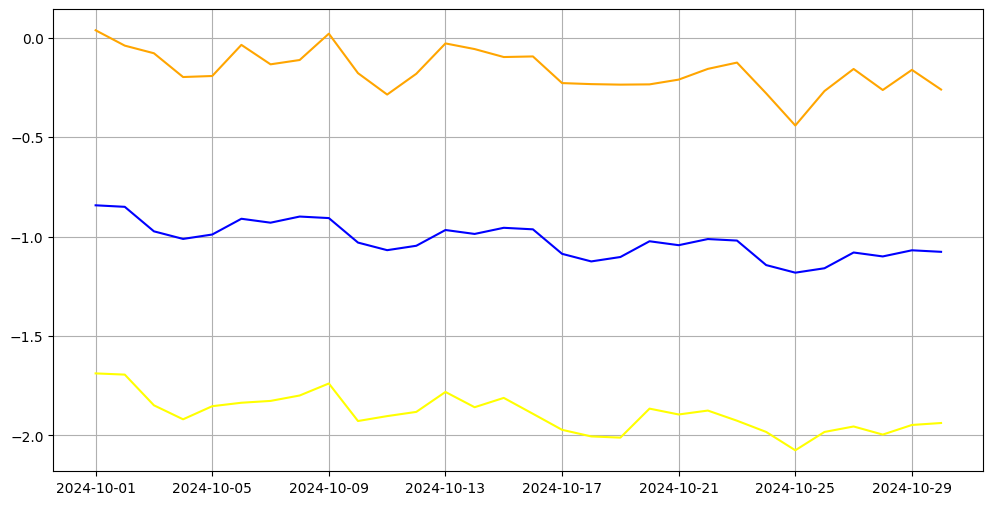

In [22]:
plt.figure(figsize=(12, 6))

plt.plot(futuro['ds'], futuro['yhat'], label='yhat', color='blue')
plt.plot(futuro['ds'], futuro['yhat_lower'], label='yhat_lower', color='yellow')
plt.plot(futuro['ds'], futuro['yhat_upper'], label='yhat_upper', color='orange')

plt.grid(True)
plt.show()

In [23]:
valor_futuro = futuro.loc[futuro['ds'] < '2024-10-30',['yhat']].sum()
#valor_futuro

In [24]:
valor_teste = df_test['y'].sum()
valor_teste

-16.77045577373354

In [25]:
((valor_futuro / valor_teste)-1)*100

yhat    75.761855
dtype: float64

In [26]:
#fig2 = m.plot_components(forecast)

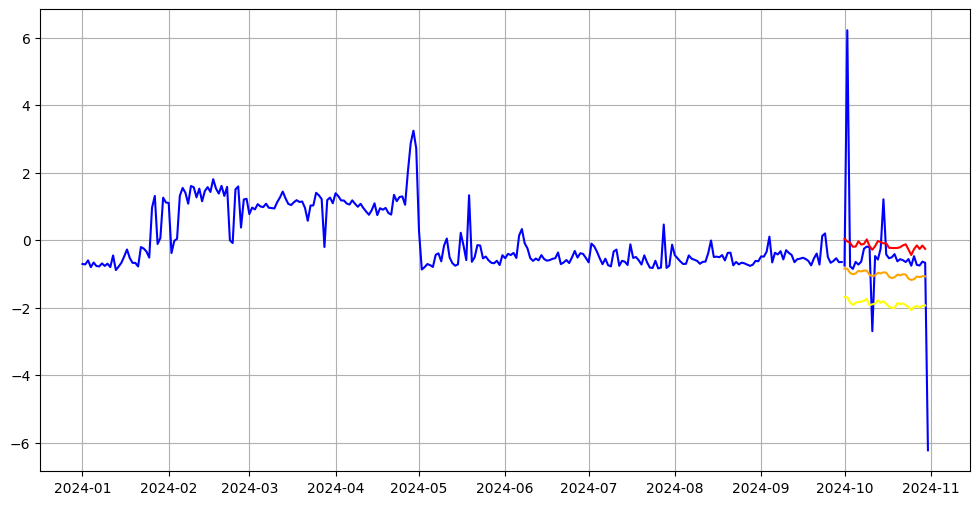

In [27]:
plt.figure(figsize=(12, 6))

plt.plot(df_test['ds'], df_test['y'], label='Dataset 1', color='blue')
plt.plot(df_train['ds'], df_train['y'], label='Dataset 1', color='blue')

plt.plot(futuro['ds'], futuro['yhat'], label='yhat', color='orange')
plt.plot(futuro['ds'], futuro['yhat_lower'], label='yhat_lower', color='yellow')
plt.plot(futuro['ds'], futuro['yhat_upper'], label='yhat_upper', color='red')

plt.grid(True)
plt.show()

In [28]:
futuro[['yhat_upper','yhat','yhat_lower']].sum()

yhat_upper    -4.896959
yhat         -30.552628
yhat_lower   -56.685703
dtype: float64

In [30]:
print(df_test['ds'].min())
print(df_test['ds'].max())

2024-10-01 00:00:00
2024-11-16 00:00:00


In [31]:
futuro.loc[futuro['ds']<='2024-12-31',['yhat_upper','yhat','yhat_lower']].sum()

yhat_upper     1.812296
yhat          -6.377229
yhat_lower   -14.542862
dtype: float64

In [32]:
valor_teste

86.2303938140124

In [33]:
futuro.loc[futuro['ds']<'2025-06-01',['yhat_upper','yhat','yhat_lower']].sum()

yhat_upper     1.812296
yhat          -6.377229
yhat_lower   -14.542862
dtype: float64